In [1]:
from ipywidgets import interact
from fastai.basics import *

In [2]:
# Function plotting function
plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)


# Gradien decent

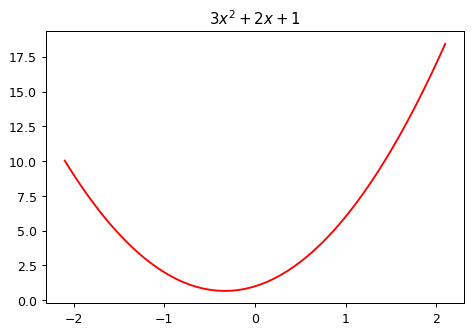

In [22]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2+2x+1$")

We create a function that allows us to test different parameters for quadratic equations

In [4]:
def quad(a,b,c,x): return a*x**2+b*x+c

quad(3,2,1,1.5)

10.75

In [5]:
from functools import partial
def mk_quad(a,b,c): return partial(quad,a,b,c)

Using `partial()` we can fix the values of the function. 

In [6]:
f = mk_quad(3,2,1)
f(1.5)

10.75

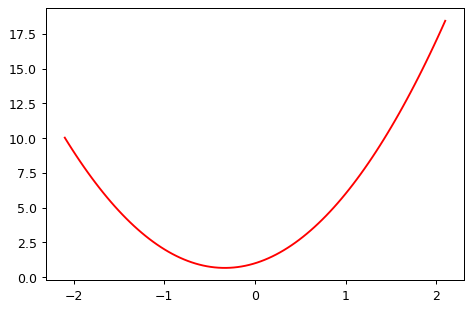

In [7]:
plot_function(f)

We will create dummy data that matches the shape of the function with some noise added.

In [8]:
from numpy.random import normal,seed,uniform
np.random.seed(42)
def noise(x,scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x*(1+noise(x,mult))+noise(x,add)

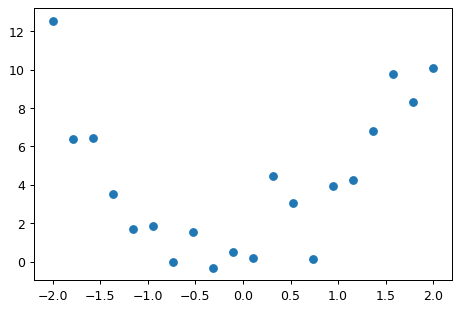

In [9]:
x = torch.linspace(-2,2,steps=20)[:,None]
y = add_noise(f(x),0.3,1.5)
plt.scatter(x,y)

We will interactively recreate the curve

In [10]:
@interact(a=1.5,b=1.5,c=1.5)
def plot_quad(a,b,c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c),ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Moving them manually is not feasible for millions of parameters. To automate this process we need to first define a loss function - a function that tells us whether we are getting better of we are getting worse.

In [11]:
# Define mean squared error
def mse(preds,acts): return ((preds-acts)**2).mean()

We will do the same but we will calculate the loss

In [12]:
@interact(a=1.5,b=1.5,c=1.5)
def plot_quad(a,b,c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mse(f(x),y)
    plot_function(f,ylim=(-3,12),title=f'MSE: {loss:.2f}')

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

# Automatic gradient descent

To automate this, we need to figure out what effect the movement in each of the parameters has in the loss. To do this we will calculate the derivative.

In [13]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x),y)

In [14]:
quad_mse([1.5,1.5,1.5])

tensor(5.8336, dtype=torch.float64)

We will create a tensor and call `requires_grad()` for it to calculate the gradient of the numbers when they are used in a calculator.

In [15]:
abc = torch.tensor([1.5,1.5,1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [16]:
loss = quad_mse(abc)
loss

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)

The gradient (derivative) of the values is now available by calling `loss.backward()`

In [17]:
loss.backward()

A new attribute has been added to our tensor.

In [18]:
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

This now tells us by how much the loss will be affected for every unit that the parameters are modified. Given that we want to reduce the loss, we need to adjust our parameters by the negative of the gradient (two negatives make a possitive).

In [19]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)
    
print(f'loss={loss:.2f}')

loss=5.49


This will create a set of parameters that are a little larger (substracted a negative) that will reduce the loss. By using `requires_grad_()`, pytorch will calculate the gradient of the values every time they are used in a function. Given that they will be used in the `abc -= abc.grad*0.001` function, we need to use `torch.no_grad()` so that no gradients are calculated because we only want to calculate the gradients of our loss function, not other functions.

This will be automated by:
1. Calculating the mse of the quadratic
2. Call backward
3. Substract the gradient times a small number from the gradient


In [20]:
for i in range(20):
    loss = quad_mse(abc) # Calculate our loss
    loss.backward() # Calculate our gradients
    with torch.no_grad(): abc -= abc.grad*0.001 # Substract our gradients
    print(f'step={i}; loss={loss:.2f}')
    

step=0; loss=5.49
step=1; loss=5.43
step=2; loss=5.33
step=3; loss=5.22
step=4; loss=5.08
step=5; loss=4.92
step=6; loss=4.75
step=7; loss=4.57
step=8; loss=4.39
step=9; loss=4.20
step=10; loss=4.02
step=11; loss=3.86
step=12; loss=3.70
step=13; loss=3.57
step=14; loss=3.45
step=15; loss=3.36
step=16; loss=3.29
step=17; loss=3.25
step=18; loss=3.22
step=19; loss=3.23


The coefficients at this point get adjusted to minimise loss.

In [21]:
abc

tensor([2.3400, 0.9020, 1.6075], requires_grad=True)

# Function approximation

Neural networks can approximate any function by using matrix multiplication and rectified linear units.

In [23]:
# Rectified linear unit
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y,0.)

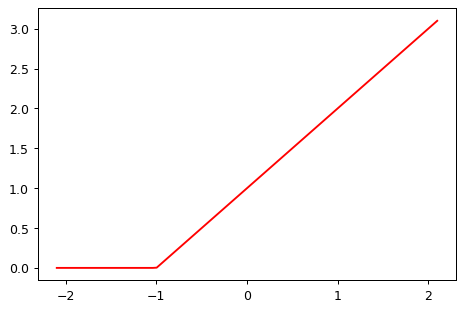

In [24]:
plot_function(partial(rectified_linear, 1,1))

 A single ReLU does not provide much flexibility but when several are added to each other it increases the function's flexibility.

In [27]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x)+rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1,b1,m2,b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(0))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…